In [1]:
# src/evaluate_melody_similarity.py

from pathlib import Path
import numpy as np
from collections import defaultdict
import random

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------------
# Paths
# ---------------------------------------------------------

SNIPPETS_PATH = Path("../data/processed/snippets.npz")
EMBED_PATH    = Path("../data/processed/autoencoder_embeddings.npz")


# ---------------------------------------------------------
# Data loading and splitting
# ---------------------------------------------------------

def load_snippets(snippets_path: Path = SNIPPETS_PATH):
    data = np.load(snippets_path, allow_pickle=True)
    intervals = data["intervals"]   # (N, L)
    durations = data["durations"]   # (N, L)
    song_ids  = data["song_ids"]    # (N,)
    midi_filenames = data.get("midi_filenames", None)
    return intervals, durations, song_ids, midi_filenames


def load_embeddings(embed_path: Path = EMBED_PATH):
    data = np.load(embed_path, allow_pickle=True)
    embeddings = data["embeddings"]     # (N, H)
    song_ids   = data["song_ids"]
    midi_filenames = data.get("midi_filenames", None)
    return embeddings, song_ids, midi_filenames


def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three np.arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val   = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs   = unique_songs[n_train:n_train + n_val]
    test_songs  = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx   = idx_for(val_songs)
    test_idx  = idx_for(test_songs)

    return train_idx, val_idx, test_idx


# ---------------------------------------------------------
# Baseline: edit distance on interval sequences
# ---------------------------------------------------------

def levenshtein_distance(seq1, seq2):
    """
    Basic Levenshtein edit distance between two 1D integer sequences.
    Complexity O(L^2) but L is small (~32), so fine.
    """
    len1, len2 = len(seq1), len(seq2)
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,      # deletion
                dp[i][j - 1] + 1,      # insertion
                dp[i - 1][j - 1] + cost,  # substitution
            )
    return dp[len1][len2]


def precision_at_k_baseline(intervals, song_ids, test_idx, ks=(5, 10), max_queries=200, seed=0):
    """
    Evaluate baseline edit-distance retrieval on test snippets.

    For each query in a subset of test_idx, find nearest neighbors among test_idx.
    Compute Precision@K: fraction of neighbors sharing the same song_id.
    """
    rng = np.random.default_rng(seed)
    test_idx = np.array(test_idx)
    N_test = len(test_idx)

    if N_test == 0:
        raise ValueError("Test set is empty.")

    if max_queries is not None and max_queries < N_test:
        query_indices = rng.choice(test_idx, size=max_queries, replace=False)
    else:
        query_indices = test_idx

    ks = sorted(ks)
    prec_sums = {k: 0.0 for k in ks}
    num_queries = len(query_indices)

    print(f"[Baseline] Evaluating on {num_queries} test queries...")

    for count, qi in enumerate(query_indices, start=1):
        q_seq = intervals[qi]
        # distances to all other test snippets
        dists = []
        for tj in test_idx:
            if tj == qi:
                dists.append(np.inf)
            else:
                d = levenshtein_distance(q_seq, intervals[tj])
                dists.append(d)
        dists = np.array(dists)
        # sort by distance (smallest = most similar)
        sorted_idx_local = np.argsort(dists)

        # map back to global snippet indices
        neighbors = test_idx[sorted_idx_local]

        for k in ks:
            topk = neighbors[:k]
            hits = (song_ids[topk] == song_ids[qi]).sum()
            prec_sums[k] += hits / k

        if count % 20 == 0 or count == num_queries:
            print(f"  Processed {count}/{num_queries} queries", end="\r")

    print()

    prec_at_k = {k: prec_sums[k] / num_queries for k in ks}
    return prec_at_k


# ---------------------------------------------------------
# Embedding-based retrieval and metrics
# ---------------------------------------------------------

def cosine_sim_matrix(embeddings, query_vec):
    """
    embeddings: (N, H)
    query_vec: (H,)
    returns: (N,) cosine similarities
    """
    emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    q_norm   = query_vec / np.linalg.norm(query_vec)
    return emb_norm @ q_norm


def precision_at_k_embeddings(embeddings, song_ids, test_idx, ks=(5, 10), max_queries=500, seed=0):
    """
    Evaluate embedding-based retrieval with cosine similarity on test snippets.
    """
    rng = np.random.default_rng(seed)
    test_idx = np.array(test_idx)
    N_test = len(test_idx)

    if N_test == 0:
        raise ValueError("Test set is empty.")

    if max_queries is not None and max_queries < N_test:
        query_indices = rng.choice(test_idx, size=max_queries, replace=False)
    else:
        query_indices = test_idx

    ks = sorted(ks)
    prec_sums = {k: 0.0 for k in ks}
    num_queries = len(query_indices)

    print(f"[Embeddings] Evaluating on {num_queries} test queries...")

    for count, qi in enumerate(query_indices, start=1):
        q_emb = embeddings[qi]
        sims = cosine_sim_matrix(embeddings[test_idx], q_emb)  # similarities only within test set
        # set similarity with itself to -inf so it never appears in neighbors
        self_pos = np.where(test_idx == qi)[0]
        if len(self_pos) == 1:
            sims[self_pos[0]] = -np.inf

        sorted_idx_local = np.argsort(-sims)  # descending similarity
        neighbors = test_idx[sorted_idx_local]

        for k in ks:
            topk = neighbors[:k]
            hits = (song_ids[topk] == song_ids[qi]).sum()
            prec_sums[k] += hits / k

        if count % 50 == 0 or count == num_queries:
            print(f"  Processed {count}/{num_queries} queries", end="\r")

    print()

    prec_at_k = {k: prec_sums[k] / num_queries for k in ks}
    return prec_at_k


# ---------------------------------------------------------
# Retrieval demo helpers
# ---------------------------------------------------------

def demo_retrieval_for_query(
    query_idx,
    intervals,
    embeddings,
    song_ids,
    midi_filenames=None,
    top_k=5
):
    """
    Print neighbors for a single query using:
      - Baseline edit distance
      - Embedding cosine similarity
    """
    print(f"=== RETRIEVAL DEMO FOR QUERY {query_idx} ===")
    print(f"song_id={song_ids[query_idx]}")
    if midi_filenames is not None:
        print("file:", midi_filenames[song_ids[query_idx]])

    # Baseline
    print("\n[Baseline] Nearest neighbors by edit distance:")
    dists = []
    N = intervals.shape[0]
    q_seq = intervals[query_idx]
    for j in range(N):
        if j == query_idx:
            dists.append(np.inf)
        else:
            dists.append(levenshtein_distance(q_seq, intervals[j]))
    dists = np.array(dists)
    nn_baseline = np.argsort(dists)[:top_k]
    for j in nn_baseline:
        fname = midi_filenames[song_ids[j]] if midi_filenames is not None else "N/A"
        print(f"  idx={j:4d}, song_id={song_ids[j]}, file={fname}, dist={dists[j]:.1f}")

    # Embeddings
    print("\n[Embeddings] Nearest neighbors by cosine similarity:")
    sims = cosine_sim_matrix(embeddings, embeddings[query_idx])
    sims[query_idx] = -np.inf
    nn_embed = np.argsort(-sims)[:top_k]
    for j in nn_embed:
        fname = midi_filenames[song_ids[j]] if midi_filenames is not None else "N/A"
        print(f"  idx={j:4d}, song_id={song_ids[j]}, file={fname}, sim={sims[j]:.3f}")


# ---------------------------------------------------------
# Visualization: PCA of embeddings
# ---------------------------------------------------------

def plot_pca_embeddings(embeddings, song_ids, num_points=1000, seed=0):
    """
    Simple PCA plot of embeddings, colored by song_id (mod a palette size).
    """
    rng = np.random.default_rng(seed)
    N = embeddings.shape[0]
    if num_points is not None and num_points < N:
        idx = rng.choice(np.arange(N), size=num_points, replace=False)
    else:
        idx = np.arange(N)

    emb_sample = embeddings[idx]
    song_sample = song_ids[idx]

    pca = PCA(n_components=2)
    coords = pca.fit_transform(emb_sample)

    plt.figure(figsize=(6, 6))
    # compress song labels into a manageable color range
    unique_songs = np.unique(song_sample)
    song_to_color = {s: i for i, s in enumerate(unique_songs)}
    colors = [song_to_color[s] for s in song_sample]

    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=colors, s=8, alpha=0.7, cmap="tab20")
    plt.title("PCA of Melody Embeddings (colored by song)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

In [2]:
# ---------------------------------------------------------
# Main entry point (for script use)
# ---------------------------------------------------------

def main():
    print("Loading snippets and embeddings...")
    intervals, durations, song_ids_snip, midi_filenames_snip = load_snippets()
    embeddings, song_ids_emb, midi_filenames_emb = load_embeddings()

    # Sanity check
    assert intervals.shape[0] == embeddings.shape[0], "Snippets and embeddings must align!"
    assert np.array_equal(song_ids_snip, song_ids_emb), "song_ids must match between files."

    song_ids = song_ids_snip
    midi_filenames = midi_filenames_snip if midi_filenames_snip is not None else midi_filenames_emb

    train_idx, val_idx, test_idx = split_by_song(song_ids)
    print(f"Total snippets: {len(song_ids)}")
    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # ----- Baseline evaluation -----
    baseline_prec = precision_at_k_baseline(
        intervals=intervals,
        song_ids=song_ids,
        test_idx=test_idx,
        ks=(5, 10),
        max_queries=200,
    )
    print("\nBaseline Precision@K (edit distance on intervals):")
    for k, v in baseline_prec.items():
        print(f"  P@{k} = {v:.4f}")

    # ----- Embedding evaluation -----
    embed_prec = precision_at_k_embeddings(
        embeddings=embeddings,
        song_ids=song_ids,
        test_idx=test_idx,
        ks=(5, 10),
        max_queries=500,
    )
    print("\nAutoencoder Embedding Precision@K (cosine similarity):")
    for k, v in embed_prec.items():
        print(f"  P@{k} = {v:.4f}")

    # ----- Retrieval demo -----
    print("\n--- Example retrieval demo ---")
    random_query = random.choice(test_idx.tolist())
    demo_retrieval_for_query(
        query_idx=random_query,
        intervals=intervals,
        embeddings=embeddings,
        song_ids=song_ids,
        midi_filenames=midi_filenames,
        top_k=5,
    )

    # ----- PCA plot -----
    print("\nPlotting PCA of embeddings...")
    plot_pca_embeddings(embeddings, song_ids, num_points=1000)


Loading snippets and embeddings...
Total snippets: 35878
Train: 24902, Val: 5346, Test: 5630
[Baseline] Evaluating on 200 test queries...
  Processed 200/200 queries

Baseline Precision@K (edit distance on intervals):
  P@5 = 0.4150
  P@10 = 0.3175
[Embeddings] Evaluating on 500 test queries...
  Processed 500/500 queries

Autoencoder Embedding Precision@K (cosine similarity):
  P@5 = 0.3168
  P@10 = 0.2672

--- Example retrieval demo ---
=== RETRIEVAL DEMO FOR QUERY 17582 ===
song_id=445
file: sisosig.mid

[Baseline] Nearest neighbors by edit distance:
  idx=14078, song_id=357, file=sweet_caroline6_A130.mid, dist=0.0
  idx=4367, song_id=115, file=JACKSON.Smooth criminal K.mid, dist=15.0
  idx=8097, song_id=212, file=Jane_Funk.mid, dist=15.0
  idx=12449, song_id=315, file=One_Last_Breath_3.mid, dist=16.0
  idx=15917, song_id=401, file=Peg.mid, dist=16.0

[Embeddings] Nearest neighbors by cosine similarity:
  idx=14078, song_id=357, file=sweet_caroline6_A130.mid, sim=1.000
  idx=1190, s

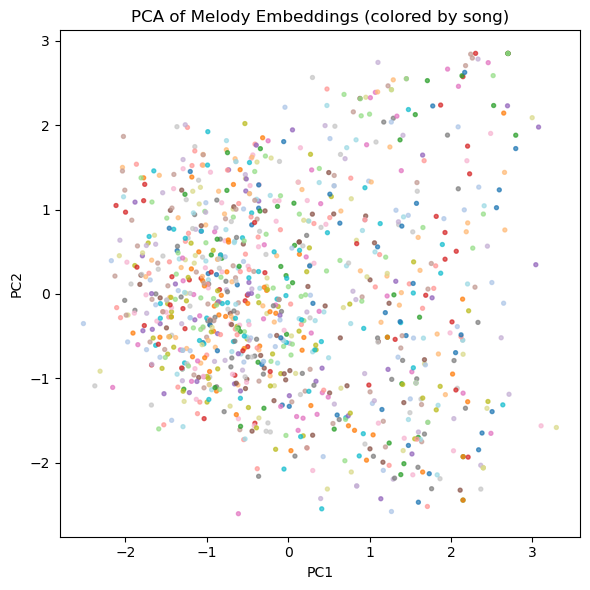

In [3]:
main()